In [82]:
from __future__ import division

import numpy as np
import pandas as pd

from scipy import stats
from statsmodels.stats import weightstats as wsm
from statsmodels.stats.proportion import proportion_confint

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set(font_scale=1.5)

In [83]:
import warnings
warnings.filterwarnings('ignore')

In [84]:
credit_data = pd.read_csv('credit_card_default_analysis.csv')

Посмотрим первым делом на сами данные

In [85]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID           30000 non-null int64
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
default      30000 non-null int64
dtypes: int64(25)
memory usage: 5.7 MB


Поля в предоставляемых данных имеют следующий смысл: 

* __LIMIT_BAL__:  размер кредитного лимита (в том числе и на семью клиента)
* __SEX__: пол клиента (1 = мужской, 2 = женский )
* __EDUCATION__: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5= прочее; 6 = нет данных ).
* __MARRIAGE__: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных). 
* __AGE__: возраст в годах
* __PAY_0__ - __PAY_6__: 
    * История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ... Pay_0 - платеж в сентябре. 
    Платеж = (0 = исправный платеж, 1=задержка в один месяц, 2=задержка в 2 месяца ...)
* __BILL_AMT1__ - __BILL_AMT6__:  
    * задолженность,  BILL_AMT6 - на апрель, BILL_AMT1 - на сентябрь 
* __PAY_AMT1__ - __PAY_AMT6__: 
    * сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре 
* __default__ - индикатор невозврата денежных средств

In [86]:
credit_data.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,0.356767,0.320033,0.304067,0.258767,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,0.760594,0.801727,0.790589,0.761113,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,0.000000,0.000000,0.000000,0.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [87]:
credit_data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


Проверим, нет ли пропущенных значений

In [88]:
credit_data.isnull().sum()

ID           0
LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
PAY_0        0
PAY_2        0
PAY_3        0
PAY_4        0
PAY_5        0
PAY_6        0
BILL_AMT1    0
BILL_AMT2    0
BILL_AMT3    0
BILL_AMT4    0
BILL_AMT5    0
BILL_AMT6    0
PAY_AMT1     0
PAY_AMT2     0
PAY_AMT3     0
PAY_AMT4     0
PAY_AMT5     0
PAY_AMT6     0
default      0
dtype: int64

Приступим к выполнению заданий

## 1. Размер кредитного лимита (LIMIT_BAL)

В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверим гипотезы:
* a)  о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки  
* b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних.  Значимы ли полученные результаты с практической точки зрения ?

Построим гистограммы общего распределения признака LIMIT_BAL и по отношению к метке вернул/не вернул кредит (default = 0/1)

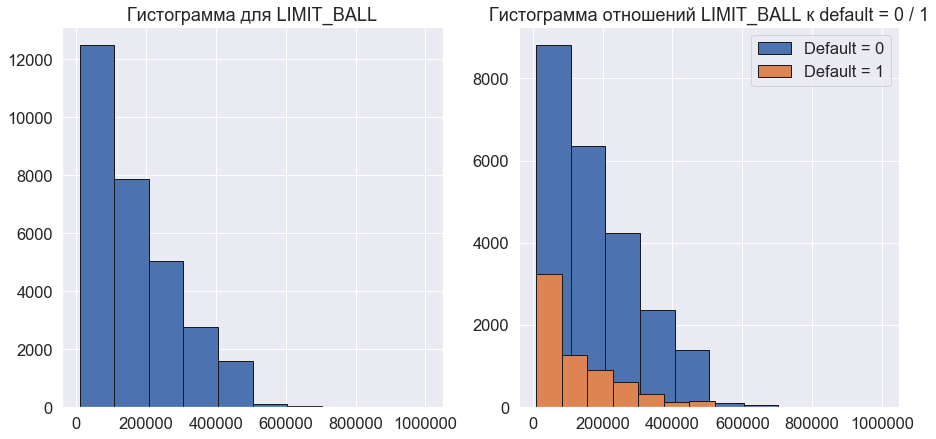

In [89]:
plt.figure(1, figsize=(15,7))
plt.subplot(121)
plt.title('Гистограмма для LIMIT_BALL')
plt.hist(credit_data['LIMIT_BAL'], edgecolor='k')

plt.subplot(122)
plt.title('Гистограмма отношений LIMIT_BALL к default = 0 / 1')
plt.hist(credit_data.LIMIT_BAL.loc[credit_data.default == 0], edgecolor='k', label='Default = 0')
plt.hist(credit_data.LIMIT_BAL.loc[credit_data.default == 1], edgecolor='k', label='Default = 1')
plt.legend()
plt.show()

### Проверим гипотезу о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки

$H_0\colon$ медианные значения кредитного лимита равны

$H_1\colon$ медианные значения кредитного лимита отличаются

In [90]:
limit_bar_0_cnt = credit_data.LIMIT_BAL[credit_data.default == 0]
limit_bar_1_cnt = credit_data.LIMIT_BAL[credit_data.default == 1]

print(f'Медиана «LIMIT_BAR» для «default=0»: {limit_bar_0_cnt.median()}')
print(f'Медиана «LIMIT_BAR» для «default=1»: {limit_bar_1_cnt.median()}')

Медиана «LIMIT_BAR» для «default=0»: 150000.0
Медиана «LIMIT_BAR» для «default=1»: 90000.0


#### Биномиальное распределение

In [91]:
def zconfint_binom(n, p, alpha=0.05):
    q = 1 - p
    m = n * p
    var = n * p * q
    z_stat = stats.norm.ppf(1 - alpha / 2)
    l_bound = int(round(m - z_stat * np.sqrt(var)))
    u_bound = int(round(m + z_stat * np.sqrt(var)))
    return (l_bound, u_bound)

In [92]:
limit_bar_0_cnt_s = np.sort(limit_bar_0_cnt.values)
limit_bar_1_cnt_s = np.sort(limit_bar_1_cnt.values)

l_ind_0, u_ind_0 = zconfint_binom(len(limit_bar_0_cnt_s), 0.5)
l_ind_1, u_ind_1 = zconfint_binom(len(limit_bar_1_cnt_s), 0.5)

print(f'95% дов. интервал медианного зн-я «LIMIT_BAL» для «default» = 0: [{limit_bar_0_cnt_s[l_ind_0]}, {limit_bar_0_cnt_s[u_ind_0]}]')
print(f'95% дов. интервал медианного зн-я «LIMIT_BAL» для «default» = 1: [{limit_bar_1_cnt_s[l_ind_1]}, {limit_bar_1_cnt_s[u_ind_1]}]')

95% дов. интервал медианного зн-я «LIMIT_BAL» для «default» = 0: [150000, 150000]
95% дов. интервал медианного зн-я «LIMIT_BAL» для «default» = 1: [80000, 90000]


In [94]:
limit_bar_0_cnt

2         90000
3         50000
4         50000
5         50000
6        500000
          ...  
29990    140000
29992     10000
29993    100000
29995    220000
29996    150000
Name: LIMIT_BAL, Length: 23364, dtype: int64

#### С помощью бутстрэп выборки

In [12]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [13]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [14]:
limit_bar_0_med_boot = list(map(np.median, get_bootstrap_samples(limit_bar_0_cnt_s, 500)))
limit_bar_1_med_boot = list(map(np.median, get_bootstrap_samples(limit_bar_1_cnt_s, 500)))

print("95% дов. интервал медианного зн-я «LIMIT_BAL» для «default» = 0:",  stat_intervals(limit_bar_0_med_boot, 0.05))
print("95% дов. интервал медианного зн-я «LIMIT_BAL» для «default» = 1:",  stat_intervals(limit_bar_1_med_boot, 0.05))

95% дов. интервал медианного зн-я «LIMIT_BAL» для «default» = 0: [150000. 150000.]
95% дов. интервал медианного зн-я «LIMIT_BAL» для «default» = 1: [80000. 90000.]


Как видно из построенных интервалов, медианные значения не пересекаются. По всей видимости можно заявить, что они различаются. Возможно, люди, не уверенные в возврате суммы кредита, первоначально берут меньшую сумму.

### Проверим гипотезу о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних

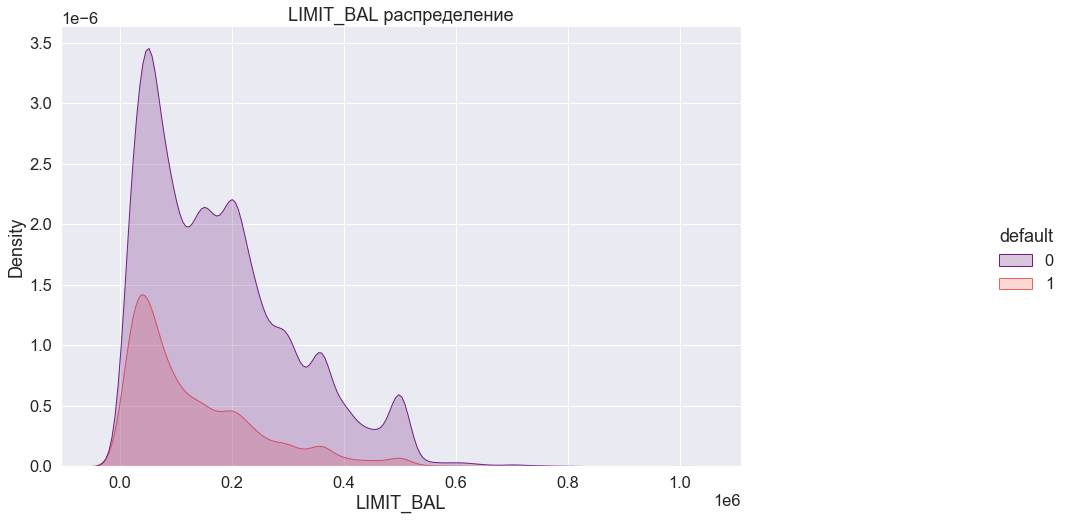

In [79]:
sns.displot(credit_data, x='LIMIT_BAL', hue='default', kind='kde', fill=True, palette='magma')
plt.title('LIMIT_BAL распределение')
plt.gcf().set_size_inches(20, 8);
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

$H_0\colon$ распределения выборок равны

$H_1\colon$ распределения выборок отличаются на величину сдвига

Используем для проверки этой гипотезы перестановочный критерий

#### Перестановочный критерий

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [15]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [16]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [17]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations=None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [18]:
def permutation_test(sample, mean, max_permutations=None, alternative='two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [19]:
print("p-value: %f" % permutation_test(limit_bar_0_cnt, limit_bar_1_cnt, max_permutations=5000))

p-value: 0.000200


Достигаемый уровень значимости позволяет отвергнуть нам нулевую гипотезу на уровне значимости 0.05.
Результат можно считать практически значимым, так как разницу в медианных значениях можно увидеть по доверительным интервалам.

## 2. Пол (SEX)

SEX: пол клиента (1 = мужской, 2 = женский )

Проверим гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается.  
Посмотрим на общее распределение пола

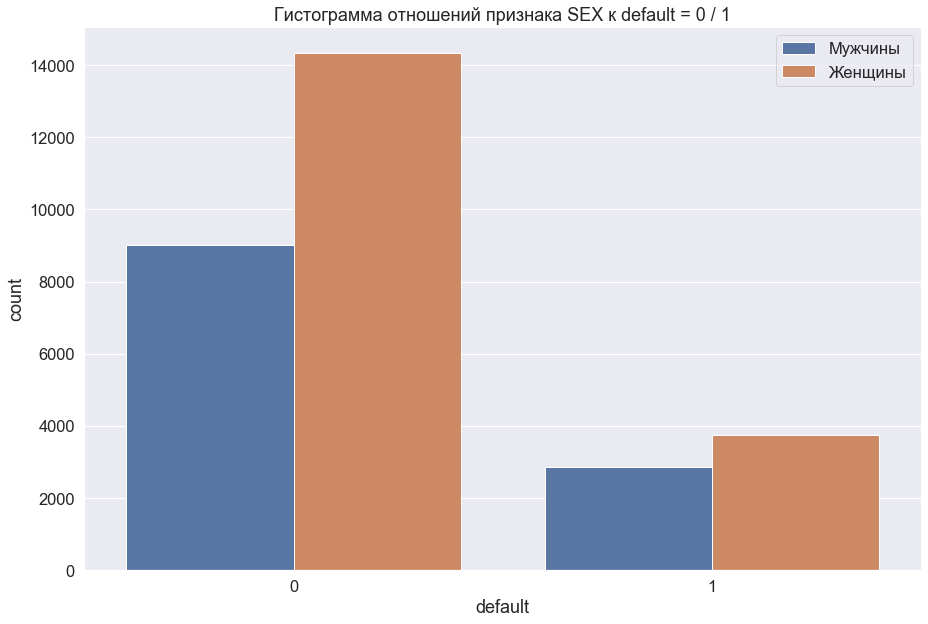

In [20]:
fig, ax = plt.subplots(figsize=(15,10))
plt.title('Гистограмма отношений признака SEX к default = 0 / 1')
sns.countplot(x='default', hue="SEX", data=credit_data, ax=ax, orient='v')
ax.set_xticklabels(['0', '1'])
ax.legend(['Мужчины', 'Женщины'])
plt.show()

Видим, что женщины чаще берут кредит, а также чаще его возвращают.

### Проверим гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается

#### Построим доверительные интервалы для доли вернувших, не вернувших и для их разности

In [21]:
credit_sex_male = credit_data[credit_data.SEX == 1].default
credit_sex_female = credit_data[credit_data.SEX == 2].default

In [22]:
wilson_interval_male = proportion_confint(credit_sex_male.sum(), credit_sex_male.shape[0], method='wilson')
wilson_interval_female = proportion_confint(credit_sex_female.sum(), credit_sex_female.shape[0], method='wilson')

In [24]:
print('Дов. интервал Уилсона для мужчин [%f, %f] шириной %f' % (wilson_interval_male[0],
                                                  wilson_interval_male[1], 
                                                  wilson_interval_male[1] - wilson_interval_male[0]))
print('Дов. интервал Уилсона для женщин [%f, %f] шириной %f' % (wilson_interval_female[0],
                                                  wilson_interval_female[1], 
                                                  wilson_interval_female[1] - wilson_interval_female[0]))

Дов. интервал Уилсона для мужчин [0.234061, 0.249450] шириной 0.015389
Дов. интервал Уилсона для женщин [0.201917, 0.213733] шириной 0.011816


Доверительные интервалы Уилсона не пересекаются, очень вероятно, что различие значимо в % возращаемых кредитов в зависимости пола. Проверим данное утверждение

#### Используем статистический Z-критерий для доли для двух независимых выборок

$H_0\colon$ гендерный состав вернувших/не вернувших кредит не отличается

$H_1\colon$ гендерный состав вернувших/не вернувших кредит отличается

In [25]:
def proportions_diff_confint_ind(sample1, sample2, alpha = 0.05):    
    z = stats.norm.ppf(1 - alpha / 2.)
    
    p1 = float(sum(sample1)) / len(sample1)
    p2 = float(sum(sample2)) / len(sample2)
    
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/ len(sample1) + p2 * (1 - p2)/ len(sample2))
    
    return (left_boundary, right_boundary)

In [26]:
def proportions_diff_z_stat_ind(sample1, sample2):
    n1 = len(sample1)
    n2 = len(sample2)
    
    p1 = float(sum(sample1)) / n1
    p2 = float(sum(sample2)) / n2 
    P = float(p1*n1 + p2*n2) / (n1 + n2)
    
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [27]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    if alternative == 'two-sided':
        return 2 * (1 - stats.norm.cdf(np.abs(z_stat))) # по свойству симметричности
    
    if alternative == 'less':
        return stats.norm.cdf(z_stat)

    if alternative == 'greater':
        return 1 - stats.norm.cdf(z_stat)

In [28]:
print("95%% доверительный интервал для разности пропорций: [%f, %f]" %\
      proportions_diff_confint_ind(credit_sex_male, credit_sex_female))

print(f"p-value: {proportions_diff_z_test(proportions_diff_z_stat_ind(credit_sex_male, credit_sex_female), 'greater')}")

95% доверительный интервал для разности пропорций: [0.024207, 0.043612]
p-value: 2.2364332608049153e-12


На уровне значимости 0.05 нулевая гипотеза о независимости дефолта от пола уверенно отвергается. При этом доверительный интервал для разности долей не содержит ноль, что потверждает наши рассуждения. Данные имеют практическую значимость, то есть признак пол явно имеет смысл включать в модель.

## 3. Признак EDUCATION

EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5 = прочее; 6 = нет данных)

Проверим гипотезу о том, что образование не влияет на то, вернет ли человек долг.  
Посмотрим на общее распределение уровня образования

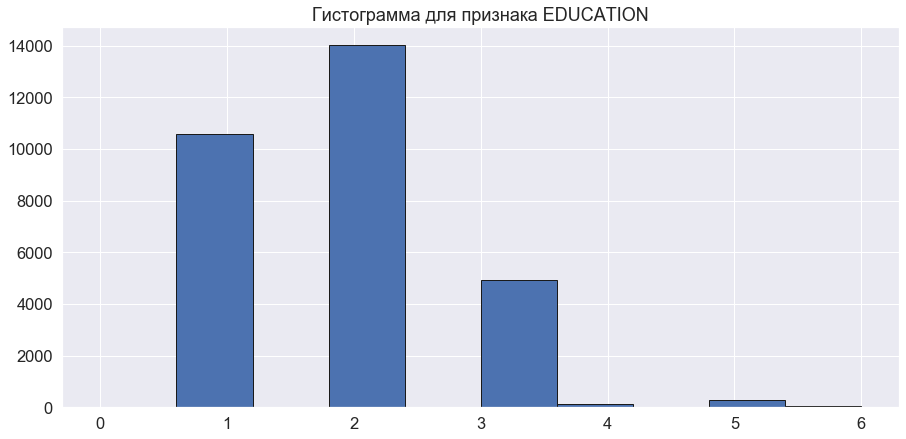

In [29]:
plt.figure(1, figsize=(15,7))
plt.title('Гистограмма для признака EDUCATION')
plt.hist(credit_data['EDUCATION'], edgecolor='k')
plt.show()

Посмотрим распределение уровня образования относительно метки возврата кредита

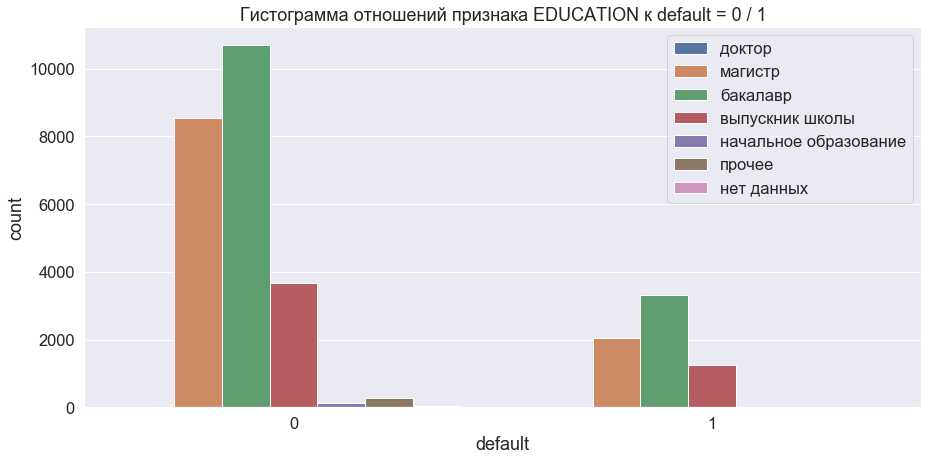

In [31]:
fig, ax = plt.subplots(figsize=(15,7))
names_legend = ['доктор', 'магистр', 'бакалавр', 'выпускник школы', 'начальное образование', 'прочее', 'нет данных']
sns.countplot(x='default', hue="EDUCATION", data=credit_data, ax=ax, orient='v')
ax.set_xticklabels(['0', '1'])
plt.title('Гистограмма отношений признака EDUCATION к default = 0 / 1')
ax.legend(names_legend)
plt.show()

Видим, что бакалавры и магистры чаще берут кредиты.  
Также заметим, что у нас довольно-таки неравномерное распределение людей по образованию. Попробуем нормализовать количество, разделяя разницу на общее кол-во людей, которое получало кредит в рассматриваемой группе. Перестроим график.

Отношение default=0 для ур. образования=0: 1.00
Отношение default=0 для ур. образования=1: 0.81
Отношение default=0 для ур. образования=2: 0.76
Отношение default=0 для ур. образования=3: 0.75
Отношение default=0 для ур. образования=4: 0.94
Отношение default=0 для ур. образования=5: 0.94
Отношение default=0 для ур. образования=6: 0.84


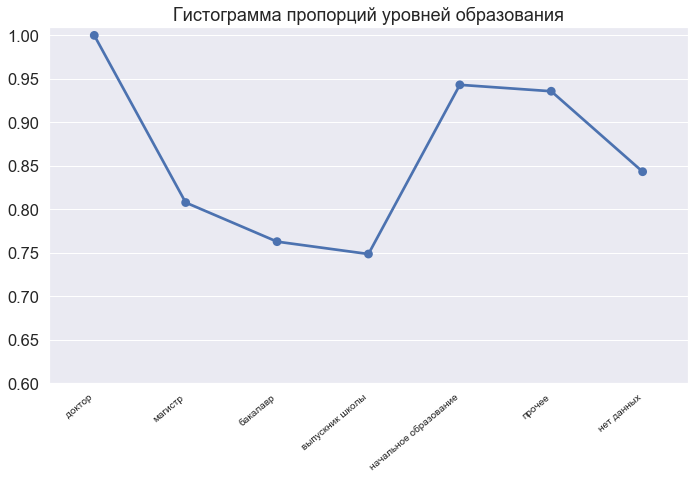

In [32]:
educ = credit_data.EDUCATION
educ_0 = credit_data.EDUCATION[credit_data.default == 0]
educ_1 = credit_data.EDUCATION[credit_data.default == 1]


educ_prop = np.empty( (len(np.unique(educ_0)), 2) )
for i, educ_val in enumerate(np.unique(educ)):
    educ_prop[i, 0] = educ_val
    educ_prop[i, 1] = educ_0[educ_0 == educ_val].shape[0] / (educ_0[educ_0 == educ_val].shape[0] + educ_1[educ_1 == educ_val].shape[0])

for educ_val, prop in educ_prop:
    print('Отношение default=0 для ур. образования=%d: %.2f' % (educ_val, prop))


plt.figure(1, figsize=(10,7))
plt.title('Гистограмма пропорций уровней образования')
graph = sns.pointplot(educ_prop[:,0], educ_prop[:,1])
graph.set_xticklabels(['доктор', 'магистр', 'бакалавр', 'выпускник школы', 'начальное образование', 'прочее', 'нет данных'], fontsize=10, rotation=40, ha="right")
graph.set_ylim(0.6, 1.01)
plt.tight_layout()

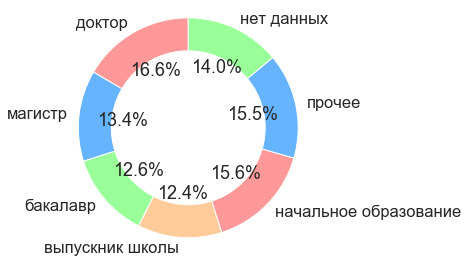

In [33]:
labels = ['доктор', 'магистр', 'бакалавр', 'выпускник школы', 'начальное образование', 'прочее', 'нет данных']
sizes = educ_prop[:, 1]

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
 
fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()
plt.show()

Исходя из графика видно, что распределение не является равномерным, следовательно, образование влияет на то, вернёт ли человек долг. Реже всего возвращают долги категории 2 и 3 (бакалавры и выпускники школ). Возвращают практически все долги только люди с докторской степенью.

### Произведём строгую проверку на соответствие данного распределения равномерному с помощью критерия согласия Пирсона Хи-квадрат

$H_0\colon$ рассматривая величина имеет равномерное распределение

$H_1\colon$ H0 не верна

In [34]:
prop_mean = educ_prop[:,1].mean()
print('Среднее по пропорциям: %.2f' % prop_mean)

Среднее по пропорциям: 0.86


In [35]:
educ_num_0 = np.array([educ_0[educ_0 == educ_val].shape[0] for educ_val in range(7)])
educ_num_1 = np.array([educ_1[educ_1 == educ_val].shape[0] for educ_val in range(7)])
educ_num_sum = educ_num_0 + educ_num_1
conf_matrix_by_educ = np.column_stack((educ_num_0, educ_num_1, educ_num_sum))

Составим таблицу сопряжённости "уровень образования" на "погашение кредита", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек.

In [36]:
exp_freq = np.array([int(prop_mean * educ_num_sum[i]) for i in range(7)])
conf_matrix_by_expr = np.column_stack((exp_freq, educ_num_0, educ_num_0 - exp_freq))

Построим таблицы сопряжённости

Text(0.5, 1, ' Ожидание / Наблюдение / Разность')

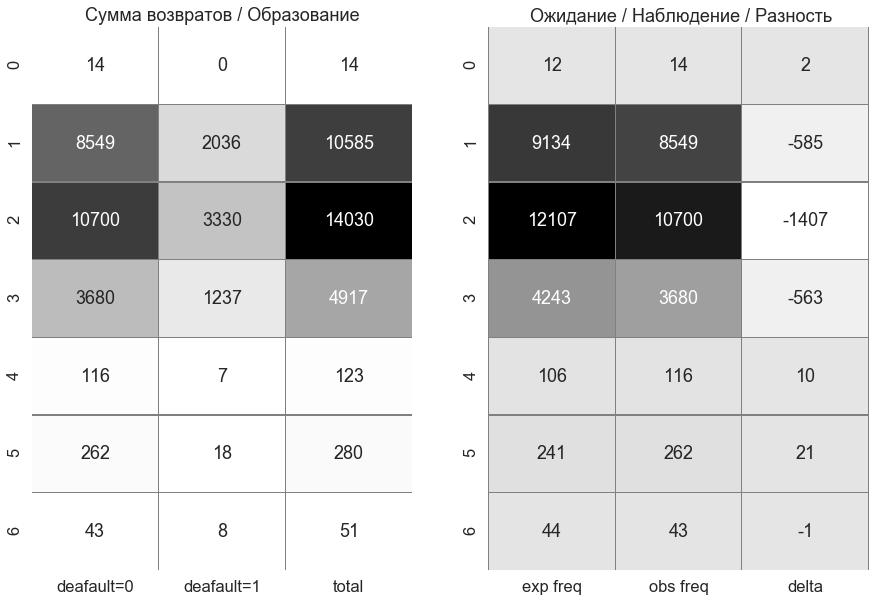

In [37]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,10))

sns.heatmap(conf_matrix_by_educ, ax=ax1,
            xticklabels=['deafault=0', 'deafault=1', 'total'],
            annot=True, fmt='d', cmap='binary', cbar=False, 
            cbar_kws={"shrink": .82}, linewidths=0.1, linecolor='gray')

sns.heatmap(conf_matrix_by_expr, ax=ax2,
            xticklabels=['exp freq', 'obs freq', 'delta'],
            annot=True, fmt='d', cmap='binary', cbar=False, cbar_kws={"shrink": .82},
                  linewidths=0.1, linecolor='gray')

ax1.set_title('Сумма возвратов / Образование')
ax2.set_title(' Ожидание / Наблюдение / Разность')

Статистика критерия хи-квадрат: $$\chi^2=\sum_{i=1}^K \frac{\left(n_i- np_i\right)^2}{np_i}$$
При справедливости нулевой гипотезы имеет распределение хи-квадрат с числом степеней свободы $K-1-m$, где $m$ - число параметров распределения, оцененных по выборке.

Или согласно таблице:
$$\chi^2(obs\ freq^n, exp\ freq^n)$$

In [38]:
stats.chisquare(educ_num_0, exp_freq, ddof = 1)

Power_divergenceResult(statistic=278.81323227661096, pvalue=3.5803812280614125e-58)

In [39]:
sum((educ_num_0 - exp_freq) ** 2 / exp_freq)

278.81323227661096

Достигаемый уровень значимости очень мал, нулевая гипотеза отвергается.  
Данный признак имеет практическую значимость для решения о выдаче кредита, так как доли возвратов для различных уровней образования отличаются.

## 4. Семейное положение (MARRIAGE)

MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных)

Проверим, как связан семейный статус с индикатором дефолта.  
Посмотрим сначала на общее распределение семейного положения

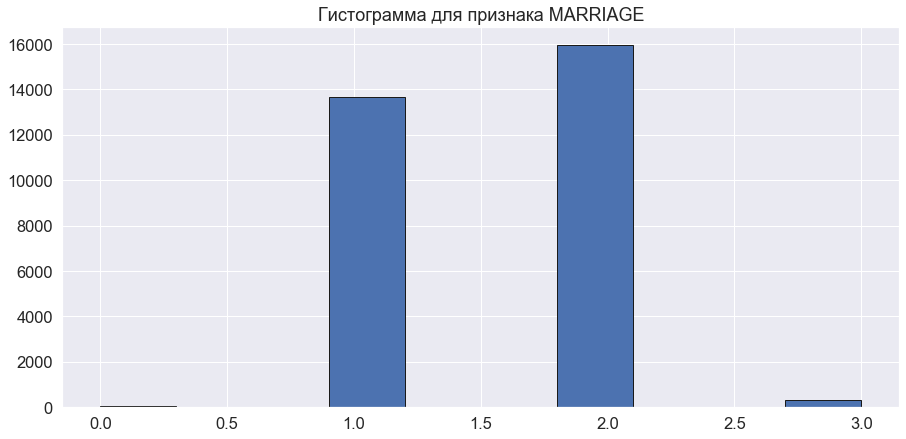

In [40]:
plt.figure(1, figsize=(15,7))
plt.title('Гистограмма для признака MARRIAGE')
plt.hist(credit_data['MARRIAGE'], edgecolor='k')
plt.show()

Оценим визуально распределение семейного положения относительно метки возврата кредита

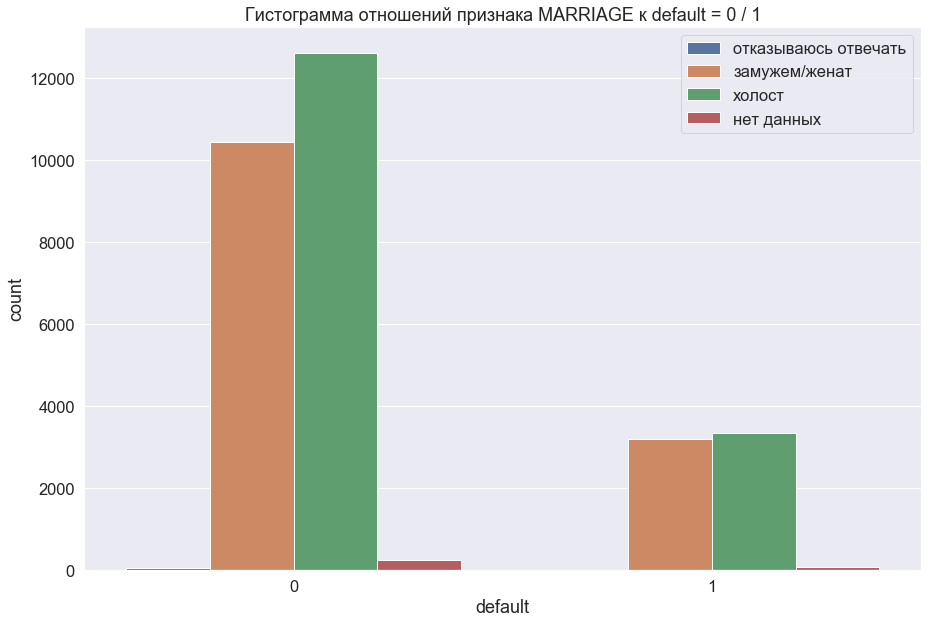

In [41]:
fig, ax = plt.subplots(figsize=(15,10))
names_legend = ['отказываюсь отвечать', 'замужем/женат', 'холост', 'нет данных']
sns.countplot(x='default', hue="MARRIAGE", data=credit_data, ax=ax, orient='v')
ax.set_xticklabels(['0', '1'])
plt.title('Гистограмма отношений признака MARRIAGE к default = 0 / 1')
ax.legend(names_legend)
plt.show()

Доли невозвратов среди женатых и холостых людей различается примерно на 10%.

### Проверим, как связан семейный статус с индикатором дефолта

In [42]:
marriage = credit_data.MARRIAGE
marriage_0 = credit_data.MARRIAGE[credit_data.default == 0]
marriage_1 = credit_data.MARRIAGE[credit_data.default == 1]
print(f'Общее число признаков marriage:\n{marriage.value_counts()}')

Общее число признаков marriage:
2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64


Аналогично предыдущей задачи составим таблицу сопряжённости для признаков default и MARRIAGE

In [43]:
lenght = len(marriage.value_counts())
marr_num_0 = np.array([marriage_0[marriage_0 == mar_val].shape[0] for mar_val in range(lenght)])
marr_num_1 = np.array([marriage_1[marriage_1 == mar_val].shape[0] for mar_val in range(lenght)])
conf_matrix_by_marriage = np.column_stack((marr_num_0, marr_num_1))

In [44]:
conf_matrix_by_marriage

array([[   49,     5],
       [10453,  3206],
       [12623,  3341],
       [  239,    84]])

Вычислим коэффициент V Крамера, который поможет измерить силу взаимосвязи между двумя категориальными переменными

$$\phi_c(X^n_1, X^n_2)=\sqrt{ \frac{\chi^2(X^n_1, X^n_2)}{n(min(K_1, K_2) - 1)}}$$

In [45]:
def cramers_stat(confusion_matrix):
    chi2, p_value = stats.chi2_contingency(confusion_matrix)[:2]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1))), p_value

In [46]:
print('V Cramer stat value: %.4f, p-value: %.10f' % cramers_stat(conf_matrix_by_marriage))

V Cramer stat value: 0.0345, p-value: 0.0000000883


Таким образом нулевая гипотеза об отсутствии связи семейного положения и уровня дефолта отвергается на уровне значимости 0.05. Значение V Крамера равно 0.0345.  
Практическая значимость присутствует, данный признак имеет смысл добавлять в модель.

## 5. Возраст (AGE)

AGE: численные значения, возраст в годах

Относительно двух групп людей вернувших и не вернувших кредит проверим следующие гипотезы:   
* a)  о равенстве медианных значений возрастов людей   
* b) о равенстве распределений  с помощью одного из подходящих непараметрических критериев проверки равенства средних

Данный признак принимает численные значения. Посмотрим на распределение

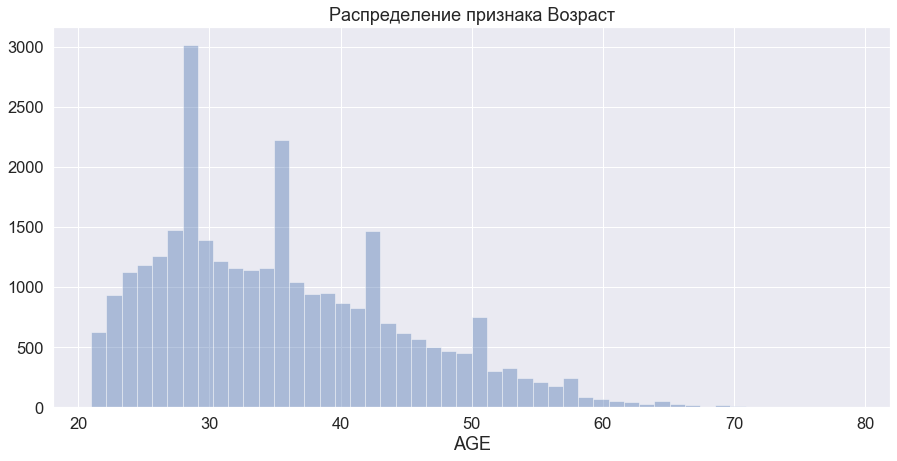

In [47]:
plt.figure(1, figsize=(15,7))
sns.distplot(credit_data.AGE, kde=False, rug=False)
plt.title('Распределение признака Возраст')
plt.show()

По графику видно, что признак «AGE» имеет тяжёлый правый хвост. Однако стоит задача сравнения, а не предсказания, поэтому логарифмировать признак не будем.  
Посмотрим на распределение возрастов относительно метки возврата кредита

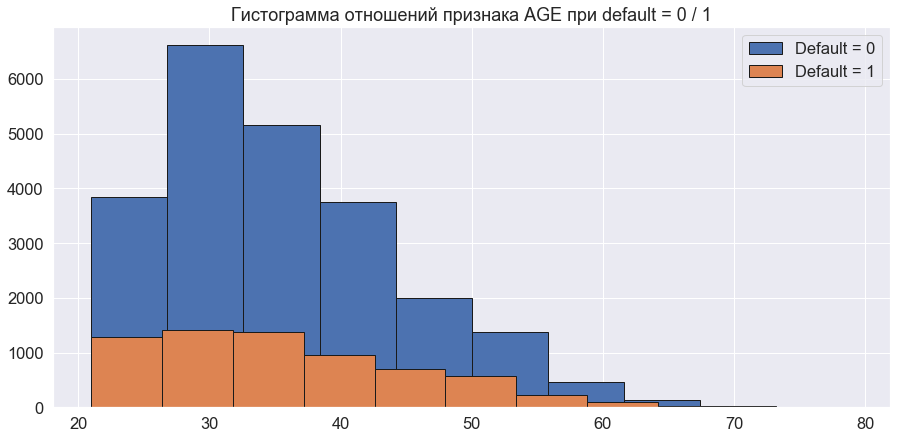

In [49]:
plt.figure(1, figsize=(15,7))
plt.hist(credit_data.AGE[credit_data.default == 0], edgecolor='k', label='Default = 0')
plt.hist(credit_data.AGE[credit_data.default == 1], edgecolor='k', label='Default = 1')
plt.title('Гистограмма отношений признака AGE при default = 0 / 1')
plt.legend()
plt.show()

Видно, что молодые люди зачастую более склонны не возвращать кредиты. Однако распределение не позволяет построить на этом вывод.

### Проверим гипотезу о равенстве медианных значений возрастов с помощью подходящей интервальной оценки

$H_0\colon$ медианные значения возрастов людей равны

$H_1\colon$ медианные значения возрастов людей отличаются

Действуем по аналогии с п.1

#### Биномиальное распределение (точный способ)

In [50]:
age_0_cnt = credit_data.AGE[credit_data.default == 0]
age_1_cnt = credit_data.AGE[credit_data.default == 1]

age_0_cnt_s = np.sort(age_0_cnt.values)
age_1_cnt_s = np.sort(age_1_cnt.values)

print(f'Медиана «AGE» для «default=0»: {age_0_cnt.median()}')
print(f'Медиана «AGE» для «default=1»: {age_1_cnt.median()}')

Медиана «AGE» для «default=0»: 34.0
Медиана «AGE» для «default=1»: 34.0


In [51]:
age_l_ind_0, age_u_ind_0 = zconfint_binom(len(age_0_cnt.values), 0.5)
age_l_ind_1, age_u_ind_1 = zconfint_binom(len(age_1_cnt.values), 0.5)

print(f'95% дов. интервал медианного зн-я «AGE» для «default» = 0: [{age_0_cnt_s[age_l_ind_0]}, {age_0_cnt_s[age_u_ind_0]}]')
print(f'95% дов. интервал медианного зн-я «AGE» для «default» = 1: [{age_1_cnt_s[age_l_ind_1]}, {age_1_cnt_s[age_u_ind_1]}]')

95% дов. интервал медианного зн-я «AGE» для «default» = 0: [34, 34]
95% дов. интервал медианного зн-я «AGE» для «default» = 1: [34, 35]


#### Доверительный интервал для медианы на основе бутстрепа

In [52]:
age_0_med_boot = list(map(np.median, get_bootstrap_samples(age_0_cnt_s, 500)))
age_1_med_boot = list(map(np.median, get_bootstrap_samples(age_1_cnt_s, 500)))

print("95% дов. интервал медианного зн-я «AGE» для «default» = 0:",  stat_intervals(age_0_med_boot, 0.05))
print("95% дов. интервал медианного зн-я «AGE» для «default» = 1:",  stat_intervals(age_1_med_boot, 0.05))

95% дов. интервал медианного зн-я «AGE» для «default» = 0: [34. 34.]
95% дов. интервал медианного зн-я «AGE» для «default» = 1: [34. 35.]


По всей видимости интервальные оценки для медианы возрастов пересекаются

### Интервальная оценка для разности медиан

In [53]:
delta_median_age = list(map(lambda x: x[1] - x[0], zip(age_0_med_boot, age_1_med_boot)))

In [54]:
print("95% confidence interval for the difference between medians",  stat_intervals(delta_median_age, 0.05))

95% confidence interval for the difference between medians [0. 1.]


Таким образом, можно заключить, что значения медиан возрастов не отличаются, так как доверительный интервал содержит 0. Подтверждение можно увидеть на боксплоте. 

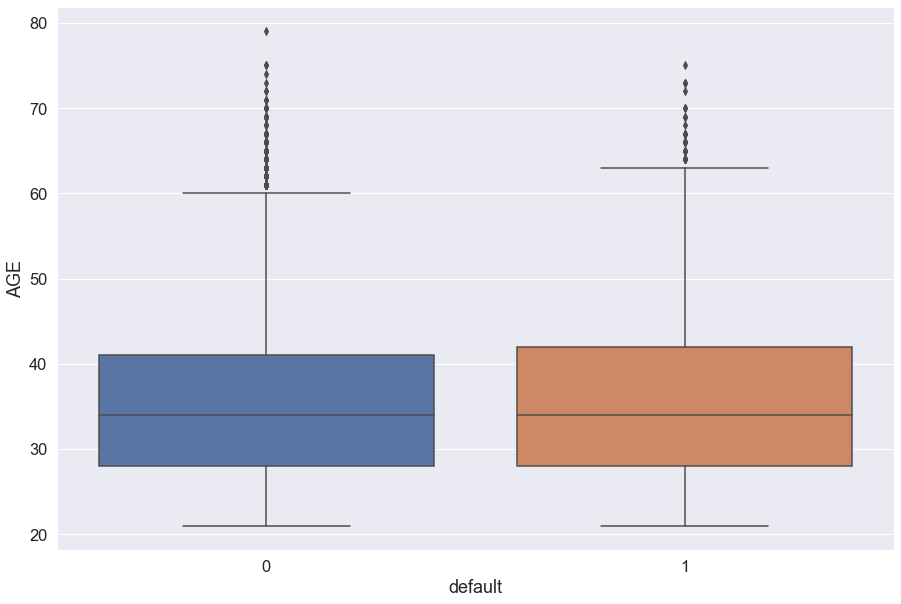

In [55]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(x='default', y='AGE', data=credit_data, ax=ax, orient='v')
plt.show()

### Проверка гипотезы о равенстве распределений с помощью одного из непараметрических критериев проверки равенства средних

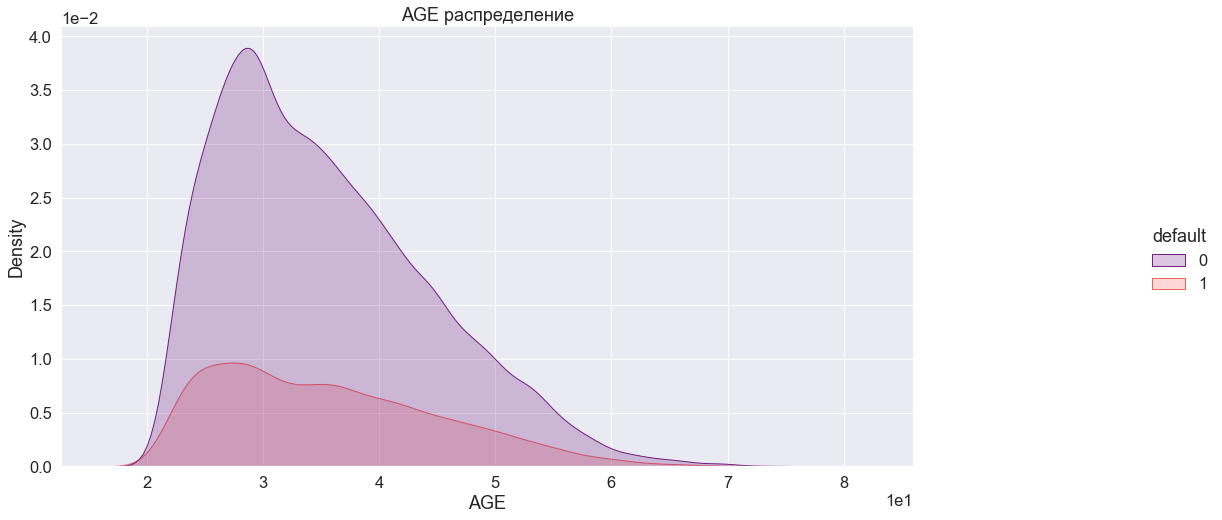

In [81]:
sns.displot(credit_data, x='AGE', hue='default', kind='kde', fill=True, palette='magma')
plt.title('AGE распределение')
plt.gcf().set_size_inches(20, 8);
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

Для проверки гипотезы снова используем перестановочный критерий для независимых выборок, придерживаясь аналогии с п.1

#### Перестановочный критерий

$H_0\colon F_{X_1}(x) = F_{X_2}(x)$

$H_1\colon F_{X_1}(x) = F_{X_2}(x + \Delta), \Delta\neq 0$

In [57]:
print("p-value: %f" % permutation_test(age_0_cnt, age_1_cnt, max_permutations=5000))

p-value: 0.016400


Достигаемый уровень значимости меньше заданного уровня 0.05, нулевая гипотеза отклоняется.  
Данный результат практически значим, разница в распределениях видна невооруженным взглядом на гистограмме выше. Эти данные могут быть полезны для модели.